# FraudGuard - Fraud Detection Pipeline

**Komplette Pipeline:** Daten laden → Rules anwenden → ML trainieren → Vergleich

## Inhalt
1. Setup & Daten laden
2. Rule-Based System
3. ML-Based System
4. Comparison & Export

---
## 1. Setup & Daten laden

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings

import sys
sys.path.append('..')
from src.rules import FraudRuleEngine
from src.features import engineer_features, select_ml_features, prepare_for_ml
from src.utils import load_data, temporal_train_test_split, print_fraud_stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Setup complete")

✓ Setup complete


In [2]:
# Load Data (50k für schnellere Verarbeitung)
df = load_data('../data/raw/fraudTrain.csv', nrows=50000)

print_fraud_stats(df)

Loading data from ../data/raw/fraudTrain.csv...
✓ Loaded 50,000 rows, 23 columns
FRAUD STATISTICS
Total Transactions: 50,000
Fraud Cases:        448
Fraud Rate:         0.90%
Legitimate Cases:   49,552


---
## 2. Rule-Based System

7 Business-Regeln anwenden

In [3]:
# Rule Engine initialisieren
engine = FraudRuleEngine()

# Regeln anwenden
print("Applying rules...\n")
df = engine.apply_all_rules(df)

print("\n✓ Rules applied")

Applying rules...

Applying fraud detection rules...
  Rule 1 (High Frequency): 6 triggered
  Rule 2 (Night Transaction): 4,858 triggered
  Rule 3 (High Amount): 2,235 triggered
  Rule 4 (Round Amount): 5 triggered
  Rule 5 (Risky Category): 20,526 triggered
✓ Applied 5 rules
  Transactions flagged (≥2 rules): 4,791

✓ Rules applied


In [4]:
# Quick Check: Rule Performance
rule_flagged = df['rule_based_prediction'].sum()
rule_correct = df[df['rule_based_prediction'] == 1]['is_fraud'].sum()

print(f"Rules flagged: {rule_flagged:,} transactions")
print(f"Actual fraud found: {rule_correct:,}")
print(f"Precision: {rule_correct / rule_flagged:.1%}" if rule_flagged > 0 else "No flags")

Rules flagged: 4,791 transactions
Actual fraud found: 248
Precision: 5.2%


---
## 3. ML-Based System

Feature Engineering → Training → Predictions

In [5]:
# Feature Engineering
print("Engineering features...\n")
df = engineer_features(df)

print(f"\n✓ Features engineered ({len(df.columns)} total columns)")

Engineering features...

Engineering features for ML...
  1. Time features...
  2. Aggregated features...
  3. Categorical features...
✓ Feature engineering complete: 47 total columns

✓ Features engineered (47 total columns)


In [6]:
# Train/Test Split (Temporal)
train_df, test_df = temporal_train_test_split(df, time_col='trans_date_trans_time', train_ratio=0.7)

print(f"\nTrain fraud rate: {train_df['is_fraud'].mean():.2%}")
print(f"Test fraud rate:  {test_df['is_fraud'].mean():.2%}")

Train: 35,000 rows (70%)
Test:  15,000 rows (30%)

Train fraud rate: 1.01%
Test fraud rate:  0.63%


In [7]:
# Select Features (ML-Only, keine Rule-Features!)
ml_features = select_ml_features(df, include_rules=False)

print(f"Selected {len(ml_features)} features for ML")

# Prepare Data
X_train, y_train = prepare_for_ml(train_df, ml_features)
X_test, y_test = prepare_for_ml(test_df, ml_features)


Selected 16 features for ML:
  Mode: ML-ONLY (without rule features)
Selected 16 features for ML

Prepared for ML:
  Features: (35000, 16)
  Labels: (35000,)
  Fraud rate: 1.01%

Prepared for ML:
  Features: (15000, 16)
  Labels: (15000,)
  Fraud rate: 0.63%


In [8]:
# Handle Class Imbalance (SMOTE)
print("Applying SMOTE...\n")

smote = SMOTE(random_state=42, sampling_strategy=0.3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.mean():.2%} fraud")
print(f"After SMOTE:  {y_train_balanced.mean():.2%} fraud")
print(f"Samples: {len(X_train_balanced):,}")

Applying SMOTE...

Before SMOTE: 1.01% fraud
After SMOTE:  23.08% fraud
Samples: 45,041


In [9]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled")

✓ Features scaled


In [10]:
# Train XGBoost
print("Training XGBoost...\n")

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

model.fit(
    X_train_scaled,
    y_train_balanced,
    eval_set=[(X_test_scaled, y_test)],
    verbose=50
)

print("\n✓ Training complete")

Training XGBoost...

[0]	validation_0-logloss:0.24544
[50]	validation_0-logloss:0.03446
[100]	validation_0-logloss:0.01817
[150]	validation_0-logloss:0.01405
[200]	validation_0-logloss:0.01219
[250]	validation_0-logloss:0.01141
[299]	validation_0-logloss:0.01121

✓ Training complete


In [11]:
# Predictions
y_pred_ml = model.predict(X_test_scaled)
y_proba_ml = model.predict_proba(X_test_scaled)[:, 1]

print(f"ML flagged: {y_pred_ml.sum():,} transactions")

ML flagged: 86 transactions


---
## 4. Comparison & Export

In [12]:
# Calculate Metrics
y_true = y_test

# Rule-Based
y_pred_rules = test_df['rule_based_prediction'].values
precision_rules = precision_score(y_true, y_pred_rules, zero_division=0)
recall_rules = recall_score(y_true, y_pred_rules, zero_division=0)
f1_rules = f1_score(y_true, y_pred_rules, zero_division=0)

# ML
precision_ml = precision_score(y_true, y_pred_ml)
recall_ml = recall_score(y_true, y_pred_ml)
f1_ml = f1_score(y_true, y_pred_ml)

# Comparison
improvement = ((f1_ml - f1_rules) / f1_rules * 100) if f1_rules > 0 else 0

print("="*80)
print("COMPARISON: RULE-BASED vs. ML-ONLY")
print("="*80)
print(f"\nRule-Based:")
print(f"  Precision: {precision_rules:.3f} ({precision_rules:.1%})")
print(f"  Recall:    {recall_rules:.3f} ({recall_rules:.1%})")
print(f"  F1-Score:  {f1_rules:.3f}")

print(f"\nML-Only:")
print(f"  Precision: {precision_ml:.3f} ({precision_ml:.1%})")
print(f"  Recall:    {recall_ml:.3f} ({recall_ml:.1%})")
print(f"  F1-Score:  {f1_ml:.3f}")

print(f"\n✅ ML improves F1-Score by {improvement:.1f}%")
print("="*80)

COMPARISON: RULE-BASED vs. ML-ONLY

Rule-Based:
  Precision: 0.036 (3.6%)
  Recall:    0.505 (50.5%)
  F1-Score:  0.067

ML-Only:
  Precision: 0.767 (76.7%)
  Recall:    0.695 (69.5%)
  F1-Score:  0.729

✅ ML improves F1-Score by 996.2%


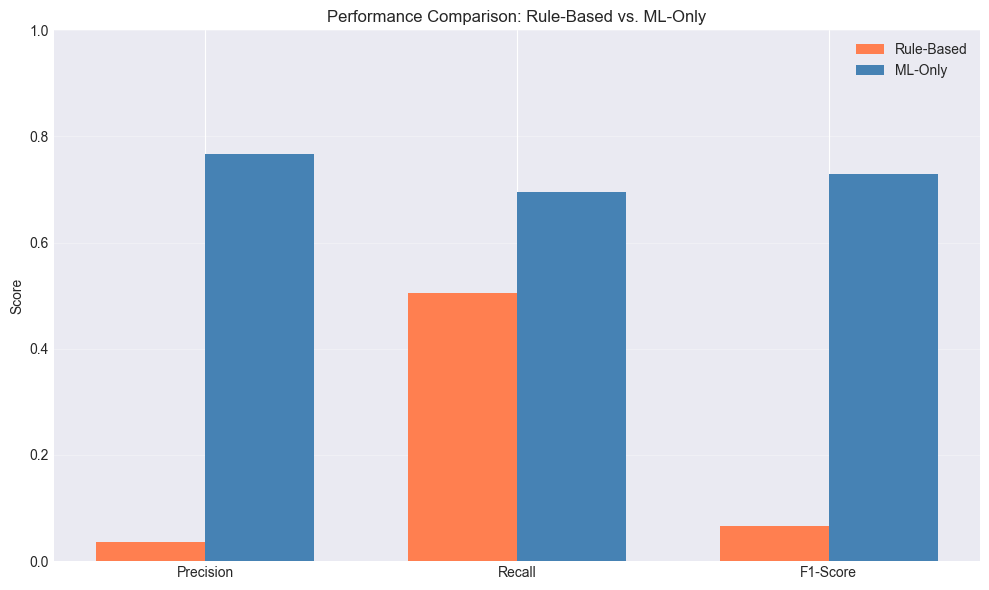

In [13]:
# Visualisierung: Comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, [precision_rules, recall_rules, f1_rules], width, label='Rule-Based', color='coral')
ax.bar(x + width/2, [precision_ml, recall_ml, f1_ml], width, label='ML-Only', color='steelblue')

ax.set_ylabel('Score')
ax.set_title('Performance Comparison: Rule-Based vs. ML-Only')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [14]:
# Prepare Export DataFrame
predictions_df = test_df.copy()

# Add ML predictions
predictions_df['ml_prediction'] = y_pred_ml
predictions_df['ml_probability'] = y_proba_ml

# Risk Level
def assign_risk_level(prob):
    if prob >= 0.7:
        return 'High'
    elif prob >= 0.3:
        return 'Medium'
    else:
        return 'Low'

predictions_df['ml_risk_level'] = predictions_df['ml_probability'].apply(assign_risk_level)

print(f"✓ Prepared {len(predictions_df):,} predictions")

✓ Prepared 15,000 predictions


In [15]:
# Export für Dashboard
predictions_df.to_csv('../data/processed/predictions_comparison.csv', index=False)

print("\n✓ Exported predictions to: data/processed/predictions_comparison.csv")
print(f"  File ready for Streamlit Dashboard!")


✓ Exported predictions to: data/processed/predictions_comparison.csv
  File ready for Streamlit Dashboard!


In [16]:
# Optional: Save Model
import joblib

joblib.dump(model, '../models/xgboost_ml_only.pkl')
joblib.dump(scaler, '../models/scaler_ml_only.pkl')
joblib.dump(ml_features, '../models/ml_features.pkl')

print("✓ Models saved to: models/")

✓ Models saved to: models/


---
## Summary

In [17]:
print("\n" + "="*80)
print("FRAUDGUARD - PIPELINE COMPLETE")
print("="*80)
print(f"\nDataset: {len(df):,} transactions ({df['is_fraud'].mean():.2%} fraud)")
print(f"Train/Test: {len(train_df):,} / {len(test_df):,}")
print(f"\nResults:")
print(f"  Rule-Based F1: {f1_rules:.3f}")
print(f"  ML-Only F1:    {f1_ml:.3f}")
print(f"  Improvement:   +{improvement:.1f}%")
print("="*80)


FRAUDGUARD - PIPELINE COMPLETE

Dataset: 50,000 transactions (0.90% fraud)
Train/Test: 35,000 / 15,000

Results:
  Rule-Based F1: 0.067
  ML-Only F1:    0.729
  Improvement:   +996.2%

Files Created:
  ✓ predictions_comparison.csv (for Dashboard)
  ✓ Model files (xgboost, scaler, features)

Next Step:
  → Run Streamlit Dashboard: streamlit run app.py
